# カタカナの画像認識モデル
手書きカタカナ「アイウエオカキクケコサシスセソ」の15文字を高い精度で識別できるモデルを構築する

## MLFlow準備

In [ ]:
import os
import configparser
import mlflow
import mlflow.sklearn
# ローカルDB方式の場合に必要。今回はローカルGUI方式のため不要
# import sqlite3

In [ ]:
# MLFlowの設定ファイル読み込み
cfg = configparser.ConfigParser()
cfg.read('./config.ini', encoding='utf-8')
# 各種パスを指定
# DB_PATH = cfg['Path']['db_path']

['./config.ini']

In [ ]:
# %% エクスペリメントの作成
# Artifactストレージの場所を指定
ARTIFACT_LOCATION = cfg['Path']['artifact_location']
# Experimentの生成
EXPERIMENT_NAME = 'cnn_tuning'
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:  # 当該Experiment存在しないとき、新たに作成
    experiment_id = mlflow.create_experiment(
                            name=EXPERIMENT_NAME,
                            artifact_location=ARTIFACT_LOCATION)
else: # 当該Experiment存在するとき、IDを取得
    experiment_id = experiment.experiment_id

## データを読む1

In [ ]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [ ]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [ ]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する
- 読み込んだtrainデータから、学習後の検証用のtestデータを除いておく。
- random_stateやtest_sizeは変更しない。

In [ ]:
X_train_all, X_test, y_train_all, y_test = train_test_split(train_data, train_label, 
                                                    test_size=0.3, random_state=1234,
                                                    shuffle=True
                                                   )

print(X_train_all.shape, X_test.shape)

(2100, 784) (900, 784)


In [ ]:
# データを間引く場合はここで調整する
X_train = X_train_all
y_train = y_train_all

- 訓練用データは2100個、検証用データは900個
- 1枚1枚の画像は724(=28*28)の格子データ

## データ拡張
** ここでAugmentorかImageDataGeneratorを実装する**
テキストp131-133にどういったデータ拡張が向いているかの記載あり
- 拡大・縮小、プーリングで吸収しきれない大幅な回転、変形（シアー、Perspective skew、Elastic distortion）、Random erasing
- 拡張された画像の中に運用時に入力される画像にできるだけ近いものが含まれていることが重要
 - Augumentor（Perspective skew、Elastic Eistortion、Random erasing）
 - ImageDataGenerator（回転、シアー、拡大・縮小）

In [ ]:
# # train(訓練データ)とtest(検証用データ)の形状を確認する
# print(f'trainの形状：{X_train.shape}')
# print(f'train_labelの形状：{y_train.shape}')
# print(f'testの形状：{X_test.shape}')
# print(f'test_labelの形状：{y_test.shape}')

## 学習

### 配列形状の変形
CNNの場合は(データ数、チャネル数、横方向、縦方向)とする

In [ ]:
train = X_train.reshape(-1, 1, 28, 28)
test = X_test.reshape(-1, 1, 28, 28)

In [ ]:
print(f'trainの形状：{train.shape}')
print(f'testの形状：{test.shape}')

trainの形状：(2100, 1, 28, 28)
testの形状：(900, 1, 28, 28)


In [ ]:
# https://dev.classmethod.jp/articles/keras-image-data-generator/
from keras.preprocessing.image import ImageDataGenerator
def plot_augmentation_image(train_sample, params):

    # 同じ画像を16個複製する
    train_samples = np.repeat(train_sample.reshape((1, *train_sample.shape)), 16, axis=0)

    # 16個に対してparamsで与えられた変換を実施
    data_generator = ImageDataGenerator(**params)
    generator = data_generator.flow(train_samples, batch_size=16)

    # 変換後のデータを取得
    batch_x = generator.next()

    # 変換後はfloat32となっているため、uint8に変換
    batch_x = batch_x.astype(np.uint8)

    # 描画処理
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        # print(batch_x[i,0].shape)
        plt.imshow(batch_x[i,0], cmap='gray')
        plt.tick_params(labelbottom='off')
        plt.tick_params(labelleft='off')
# plt.imshow(img[0,:,:], cmap='gray')


In [ ]:
# 水増し用のデータ作成
train_tmp = train[:,:,:,:]
y_tmp = y_train[:,:]
# データ数を削減
# train_tmp = train[0:2,:,:,:]
# y_tmp = y_train[0:2,:]
print(train_tmp.shape)
print(y_tmp.shape)

(2100, 1, 28, 28)
(2100, 15)


In [ ]:
# train_tmp.shape[3]

In [ ]:
params = {
    'zoom_range': [0.7, 1.3],
    'rotation_range': 30,
    # 'vertical_flip': True,
    # 'horizontal_flip': True,
    'height_shift_range': 0.1,
    'width_shift_range': 0.1,
    'shear_range': 30,
    # 'channel_shift_range': 127
}
generator = ImageDataGenerator(**params)

# train_iter = generator.flow(x=train_images, y=train_labels)
# train_iter = generator.flow(x=train_tmp, y=y_tmp)
train_tmp_t = train_tmp.transpose(0,2,3,1)
print(train_tmp_t.shape)
# train_iter = generator.flow(x=train_tmp_t, y=y_tmp, batch_size=1, save_to_dir="../1_data/idgen/",
#                  save_format='png')#, save_prefix='out_%s_from_npy_'%label)
train_iter = generator.flow(x=train_tmp_t, y=y_tmp, batch_size=1)#画像を保存しない場合

num_image = 2100 #水増しデータ数
for i in range(num_image):
    batches = train_iter.next()
    # print(batches[0].shape)
    # print(batches[1]) #これがラベル
    # 生成されたデータbatches[0]を追加する
    train_tmp_t = np.vstack([train_tmp_t, batches[0]])
    y_tmp = np.vstack([y_tmp, batches[1]])

(2100, 28, 28, 1)


In [ ]:
print(train_tmp_t.shape)
print(y_tmp.shape)

(4200, 28, 28, 1)
(4200, 15)


In [ ]:
train_added = train_tmp_t.transpose(0,3,1,2)
y_train_added = y_tmp

In [ ]:
train.shape

(2100, 1, 28, 28)

In [ ]:
print(train_added.shape)
print(y_train_added.shape)

(4200, 1, 28, 28)
(4200, 15)


- ここまででimageDataGeneratorを使ったデータ拡張を実装できた。
- あとはimageDataGeneratorのパラメータをいろいろ試してみて、データを拡張して、学習してみる。
- 【疑問】データ拡張するのは学習前？それともミニバッチ学習のバッチごと？

### ミニバッチ学習

In [ ]:
# データを間引く
# x = train[:1000,:]; t = y_train[:1000,:] # x: 訓練データ、t: テストデータ
x = train_added; t = y_train_added
# x = train; t = y_train
x = x.reshape(-1,1,28,28) # 配列形式の変形

In [ ]:
print(x.shape)

(4200, 1, 28, 28)


In [ ]:
from common.layers import SimpleConvNet
from common.optimizer import RMSProp, NesterovAG
def model_train(epochs, batch_size, filter_num, filter_size, weight_init_std):
    optimizer = RMSProp(lr=0.01, rho=0.9)
    # optimizer = NesterovAG(lr=0.01, momentum=0.9)
    
    # 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(int)

    # CNNのオブジェクト生成
    snet = SimpleConvNet(input_dim=(1, 28, 28), 
                         conv_param={'filter_num':filter_num, 'filter_size':filter_size, 'pad':0, 'stride':1},
                         pool_param={'pool_size':2, 'pad':0, 'stride':2},
                         hidden_size=100, output_size=15, weight_init_std=weight_init_std, batch_size=batch_size)

    train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

    for epoch in range(epochs):
        if np.mod(epoch,1)==0: print("epoch=%s"%epoch, iter_num)

        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            # print("it=", it)
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            x_train = x[mask]; t_train = t[mask]
            
            # 勾配の計算 (誤差逆伝播法を用いる)
            grads = snet.gradient(x_train, t_train)

            # 更新
            optimizer.update(snet.params, grads)

        ## 学習経過の記録
        # 訓練データおよびテストデータにおけるloss
        train_loss.append(snet.loss(x,  t)); test_loss.append(snet.loss(test, y_test))

        # 訓練データおよびテストデータにて精度を確認
        train_accuracy.append(snet.accuracy(x, t, batch_size)); test_accuracy.append(snet.accuracy(test, y_test, batch_size))
        print(snet.accuracy(x, t, batch_size), snet.accuracy(test, y_test, batch_size))
    return snet, train_accuracy, test_accuracy, train_loss, test_loss

In [ ]:
# x = train[:1000,:]; t = y_train[:1000,:]

# x = x.reshape(-1,1,28,28) # 配列形式の変形

# epochs = 10
# batch_size = 100

# optimizer = RMSProp(lr=0.01, rho=0.9)

# # 繰り返し回数
# xsize = x.shape[0]
# iter_num = np.ceil(xsize / batch_size).astype(int)

# # CNNのオブジェクト生成
# snet = SimpleConvNet(input_dim=(1, 28, 28), 
#                      conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
#                      pool_param={'pool_size':2, 'pad':0, 'stride':2},
#                      hidden_size=100, output_size=15, weight_init_std=0.01)

# train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

# for epoch in range(epochs):
#     if np.mod(epoch,10)==0: print("epoch=%s"%epoch)

#     # シャッフル
#     idx = np.arange(xsize)
#     np.random.shuffle(idx)

#     for it in range(iter_num):
#         """
#         ランダムなミニバッチを順番に取り出す
#         """
#         print("it=", it)
#         mask = idx[batch_size*it : batch_size*(it+1)]

#         # ミニバッチの生成
#         x_train = x[mask]; t_train = t[mask]

#         # 勾配の計算 (誤差逆伝播法を用いる)
#         grads = snet.gradient(x_train, t_train)

#         # 更新
#         optimizer.update(snet.params, grads)

#     ## 学習経過の記録
#     # 訓練データおよびテストデータにおけるloss
#     train_loss.append(snet.loss(x,  t)); test_loss.append(snet.loss(test, y_test))

#     # 訓練データおよびテストデータにて精度を確認
#     train_accuracy.append(snet.accuracy(x, t)); test_accuracy.append(snet.accuracy(test, y_test))

In [ ]:
# mlflowに記録
# epochs = 200
# batch_size = 32
# lr = 0.01
# random_seed = 1234
epochs = 100
batch_size = 100

filter_num = 30
filter_size = 5
weight_init_std = 0.01

mlflow.end_run()

# 管理IDを発行（コードの実行に対して）
with mlflow.start_run(experiment_id=experiment_id):
    trial = 0
    print("mlflow時点のbatch_size", batch_size)
    tnet, train_acc, test_acc, train_loss, test_loss = model_train(epochs, batch_size, filter_num, filter_size, weight_init_std)

    # 小数点以下３桁まで出力
    print(f"trial {trial}: batch_size={batch_size}, filter_num={filter_num},　train_accuracy={train_acc[-1]:.3}, test_accuracy={test_acc[-1]:.3}")

    # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
    mlflow.log_param("filter_num", filter_num)
    mlflow.log_param("filter_size", filter_size)
    mlflow.log_param("weight_init_std", weight_init_std)
    mlflow.log_metric("train_accuracy", train_acc[-1])
    mlflow.log_metric("test_accuracy", test_acc[-1])
    # mlflow.log_param("random_seed", random_seed)

    # mlflow.log_model(tnet, "model")

# mlflowを終了
mlflow.end_run()

mlflow時点のbatch_size 100
layers.RMSPropのrho 0.9
class初期化時の値 30 5 0 28 100 0.01
epoch=0 42
0.12976190476190477 0.14
epoch=1 42
0.5271428571428571 0.6522222222222223
epoch=2 42
0.7297619047619047 0.8544444444444445
epoch=3 42
0.7142857142857143 0.8244444444444444
epoch=4 42
0.7721428571428571 0.8511111111111112
epoch=5 42
0.8814285714285715 0.9033333333333333
epoch=6 42
0.8992857142857142 0.9144444444444444
epoch=7 42
0.9192857142857143 0.9188888888888889
epoch=8 42
0.9480952380952381 0.9166666666666666
epoch=9 42
0.9614285714285714 0.9266666666666666
epoch=10 42
0.9678571428571429 0.9288888888888889
epoch=11 42
0.9707142857142858 0.9133333333333333
epoch=12 42
0.9614285714285714 0.9155555555555556
epoch=13 42
0.9883333333333333 0.9222222222222223
epoch=14 42
0.9871428571428571 0.9255555555555556
epoch=15 42
0.9890476190476191 0.9211111111111111
epoch=16 42
0.9892857142857143 0.9088888888888889
epoch=17 42
0.9845238095238096 0.9144444444444444
epoch=18 42
0.9873809523809524 0.915555555555

In [ ]:
# mlflow.end_run()

In [ ]:
# # mlflowに記録（グリッドサーチ）
# # 管理IDを発行（コードの実行に対して）
# experiment_id = 0
# with mlflow.start_run(experiment_id=experiment_id):
#     # ハイパーパラメータの試行水準
#     cand_batch_size = [16, 32]
#     cand_lr = [0.005, 0.01]

#     trial = 0
#     for batch_size in cand_batch_size:
#         for lr in cand_lr:
#             # 管理IDを発行（各パラメータ水準に対して）
#             with mlflow.start_run(experiment_id=experiment_id, nested=True):
#                 trial += 1
#                 tnet, train_accuracy, test_accuracy, train_loss, test_loss = model_train(epochs, batch_size, lr)
#                 # model, mse, R2 = train(n_estimators, max_depth)
#                 # 小数点以下３桁まで出力
#                 print(f"trial {trial}: batch_size={batch_size}, lr={lr}, \
#                       train_accuracy={train_accuracy[-1]:.3}, test_accuracy={test_accuracy[-1]:.3}")
#                 # 追加箇所
#                 # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
#                 mlflow.log_param("batch_size", batch_size)
#                 mlflow.log_param("lr", lr)
#                 mlflow.log_metric("train_accuracy", train_accuracy[-1])
#                 mlflow.log_metric("test_accuracy", test_accuracy[-1])

#                 mlflow.sklearn.log_model(tnet, "model")


In [ ]:
# print(len(train_accuracy))
# print(len(test_accuracy))
# print(len(train_accuracy))
# print(len(test_accuracy))

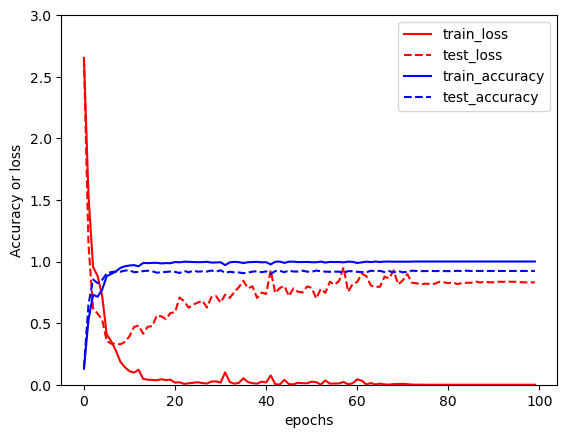

In [ ]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_acc,
             "test_accuracy":test_acc})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

In [ ]:
# # lossのグラフ化
# df_log = pd.DataFrame({"train_loss":train_loss,
#              "test_loss":test_loss,
#              "train_accuracy":train_acc,
#              "test_accuracy":test_acc})
# df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
# plt.ylabel("loss or accuracy")
# plt.xlabel("epochs")
# plt.show()

## 学習済みモデルの出力

In [ ]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)

- Google Colab. を使用している人は `katakana_model.pickle` のダウンロードを忘れないようにしよう
  - 「識別精度算出ウェブサイト」への投稿に必要な情報であるため
  - ファイルダウンロードの参考：https://blog.kikagaku.co.jp/google-colab-file#_Google_Colab